## Essencial Functions and Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import tifffile as tiff
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Read data

In [6]:
# Spectral bands in the image:
# Blue  = X[:, 0]
# Green = X[:, 1]
# Red   = X[:, 2]
# NIR   = X[:, 3]

dataset_dir = 'spotlite_dataset_loca1_date1_dir1'

images_dataset_dir = os.path.join(dataset_dir, 'images')
masks_dataset_dir = os.path.join(dataset_dir, 'masks')

# Verify if directories exist (optional, but recommended)
assert os.path.exists(images_dataset_dir), f"Images directory not found: {images_dataset_dir}"
assert os.path.exists(masks_dataset_dir), f"Masks directory not found: {masks_dataset_dir}"

image_files = sorted(os.listdir(images_dataset_dir))
mask_files = sorted(os.listdir(masks_dataset_dir))

imgs, masks = [], []

# Check if the number of files match
assert len(image_files) == len(mask_files), "Number of images and masks don't match."

for image_file, mask_file in zip(image_files, mask_files):
    image_path = os.path.join(images_dataset_dir, image_file)
    mask_path = os.path.join(masks_dataset_dir, mask_file)

    read_img = tiff.imread(image_path)
    read_mask = tiff.imread(mask_path)

    imgs.append(read_img)
    masks.append(read_mask)

imgs = np.stack(imgs)   # (N, H, W, C)
masks = np.stack(masks) # (N, H, W)

if not isinstance(imgs, np.ndarray):
    imgs = imgs.numpy()

if not isinstance(masks, np.ndarray):
    masks = masks.numpy()

print(f'shape of imgs: {imgs.shape}')
print(f"type of imgs: {type(imgs)}")
print('--------------------------------')
print(f'shape of masks: {masks.shape}')
print(f"type of masks: {type(masks)}")

unique_values = np.unique(masks)
print(f"Unique values in masks: {unique_values}")


shape of imgs: (191, 512, 512, 4)
type of imgs: <class 'numpy.ndarray'>
--------------------------------
shape of masks: (191, 512, 512)
type of masks: <class 'numpy.ndarray'>
Unique values in masks: [0 3 4]


## Convert labels in masks

In [7]:
# Convert labels in masks from 0, 3, 4 to 0, 1, 2
# where 0 is background, 1 is class 1, and 2 is class
def remap_mask(mask):
    remapped = np.zeros_like(mask, dtype=np.uint8)
    remapped[mask == 0] = 0
    remapped[mask == 3] = 1
    remapped[mask == 4] = 2
    return remapped

masks = remap_mask(masks)
print(f'shape of remapped masks: {masks.shape}')
print(f"type of remapped masks: {type(masks)}")

unique_values = np.unique(masks)
print(f"Unique values in masks: {unique_values}")

shape of remapped masks: (191, 512, 512)
type of remapped masks: <class 'numpy.ndarray'>
Unique values in masks: [0 1 2]


## Extract features and labels

In [8]:
N, H, W, C = imgs.shape
X = imgs.reshape(-1, C)       # shape = (N*H*W, 4)
y = masks.reshape(-1)         # shape = (N*H*W,)

print(f'shape of X: {X.shape}')
print(f'shape of y: {y.shape}')

# (Opcional) amostragem para acelerar treino
# idx = np.random.choice(len(y), size=100000, replace=False)
# X, y = X[idx], y[idx]

shape of X: (50069504, 4)
shape of y: (50069504,)


## Check Inbalance

Classe 0: 48,043,641 pixels (95.95%)
Classe 1: 687,567 pixels (1.37%)
Classe 2: 1,338,296 pixels (2.67%)
   class    counts    percent
0      0  48043641  95.953898
1      1    687567   1.373225
2      2   1338296   2.672876


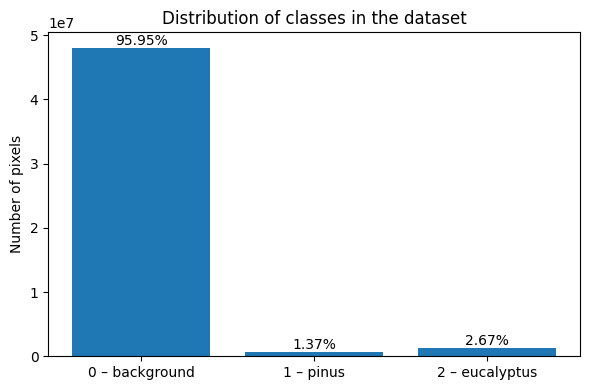

In [9]:
total_pixels = y.size
classes, counts = np.unique(y, return_counts=True)

for cls, ct in zip(classes, counts):
    pct = ct / total_pixels * 100
    print(f"Classe {cls}: {ct:,} pixels ({pct:.2f}%)")

df_dist = pd.DataFrame({
    "class":   classes,
    "counts":  counts,
    "percent": counts / total_pixels * 100
})
print(df_dist)

class_names = {
    0: "background",
    1: "pinus",
    2: "eucalyptus"
}
x_labels = [f"{cls} – {class_names[cls]}" for cls in df_dist['class']]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(df_dist['class'], df_dist['counts'])

ax.set_ylabel('Number of pixels')
ax.set_title('Distribution of classes in the dataset')

ax.set_xticks(df_dist['class'])
ax.set_xticklabels(x_labels)

for bar, pct in zip(bars, df_dist['percent']):
    x  = bar.get_x() + bar.get_width()/2
    y  = bar.get_height()
    ax.text(x, y, f"{pct:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Split training/testing

In [13]:
y = masks.reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f'shape of X_train: {X_train.shape}')
print(f'shape of y_train: {y_train.shape}')
print(f'shape of X_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')

shape of X_train: (37552128, 4)
shape of y_train: (37552128,)
shape of X_test: (12517376, 4)
shape of y_test: (12517376,)


### Train Random Forest 

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

def train_two_stage_rf(X, y, forest_params, species_params):
  # Stage 1: background (0) vs forest (1)
  y_forest = (y > 0).astype(int)
  forest_clf = RandomForestClassifier(**forest_params)
  forest_clf.fit(X, y_forest)

  # Stage 2: pinus (1) vs eucalyptus (2) only in forest pixels
  mask_f = (y > 0)
  X_fg, y_fg = X[mask_f], y[mask_f]
  species_clf = RandomForestClassifier(**species_params)
  species_clf.fit(X_fg, y_fg)

  return forest_clf, species_clf

def predict_two_stage_rf(forest_clf, species_clf, X):
  is_forest = forest_clf.predict(X).astype(bool)
  y_pred = np.zeros(X.shape[0], dtype=int)
  if is_forest.any():
    y_pred[is_forest] = species_clf.predict(X[is_forest])
  return y_pred

# --- balanced parameters ---
forest_params = {
  'n_estimators': 50, 'max_depth': 20,
  'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 42
}
species_params = {
  'n_estimators': 50, 'max_depth': 20,
  'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 42
}

# 1) Train using only X_train, y_train
forest_clf, species_clf = train_two_stage_rf(
  X_train, y_train,
  forest_params, species_params
)

# 2) Full prediction
y_pred_full = predict_two_stage_rf(forest_clf, species_clf, X_test)

# 3) Evaluation of Stage 1
y_forest_true = (y_test > 0).astype(int)
y_forest_pred = forest_clf.predict(X_test)
print("=== Stage 1: Background vs. Forest ===")
print(classification_report(
  y_forest_true, y_forest_pred,
  target_names=['Background', 'Forest'], digits=4
))

# 4) Evaluation of Stage 2 (isolated, only in REAL forest pixels)
X_test_fg = X_test[y_test > 0]
y_test_fg = y_test[y_test > 0]
y_pred_fg = species_clf.predict(X_test_fg)
print("=== Stage 2: Pinus vs. Eucalyptus (isolated evaluation) ===")
print(classification_report(
  y_test_fg, y_pred_fg,
  target_names=['Pinus', 'Eucalyptus'], digits=4
))

# 5) Full pipeline evaluation
print("=== Full Pipeline (3 classes) ===")
print(classification_report(
  y_test, y_pred_full,
  target_names=['Background', 'Pinus', 'Eucalyptus'], digits=4
))

=== Stage 1: Background vs. Forest ===
              precision    recall  f1-score   support

  Background     0.9933    0.8064    0.8902  12010910
      Forest     0.1596    0.8719    0.2698    506466

    accuracy                         0.8091  12517376
   macro avg     0.5765    0.8392    0.5800  12517376
weighted avg     0.9596    0.8091    0.8651  12517376

=== Stage 2: Pinus vs. Eucalyptus (isolated evaluation) ===
              precision    recall  f1-score   support

       Pinus     0.9058    0.9213    0.9135    171892
  Eucalyptus     0.9592    0.9508    0.9550    334574

    accuracy                         0.9408    506466
   macro avg     0.9325    0.9360    0.9342    506466
weighted avg     0.9411    0.9408    0.9409    506466

=== Full Pipeline (3 classes) ===
              precision    recall  f1-score   support

  Background     0.9933    0.8064    0.8902  12010910
       Pinus     0.0690    0.6538    0.1248    171892
  Eucalyptus     0.2696    0.9163    0.4166    334

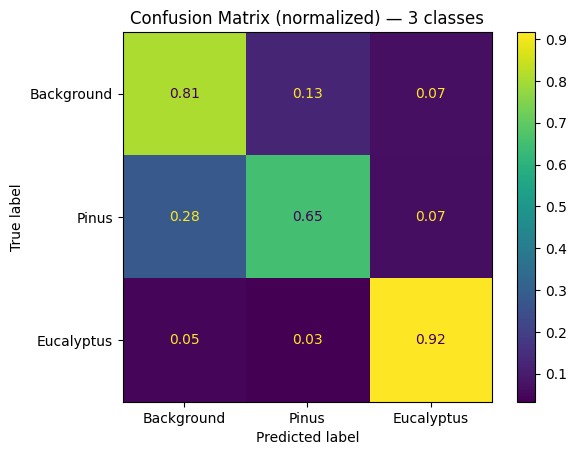

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_full,
    normalize='true',
    display_labels=['Background','Pinus','Eucalyptus'],
    values_format='.2f'
)
plt.title("Confusion Matrix (normalized) — 3 classes")
plt.show()